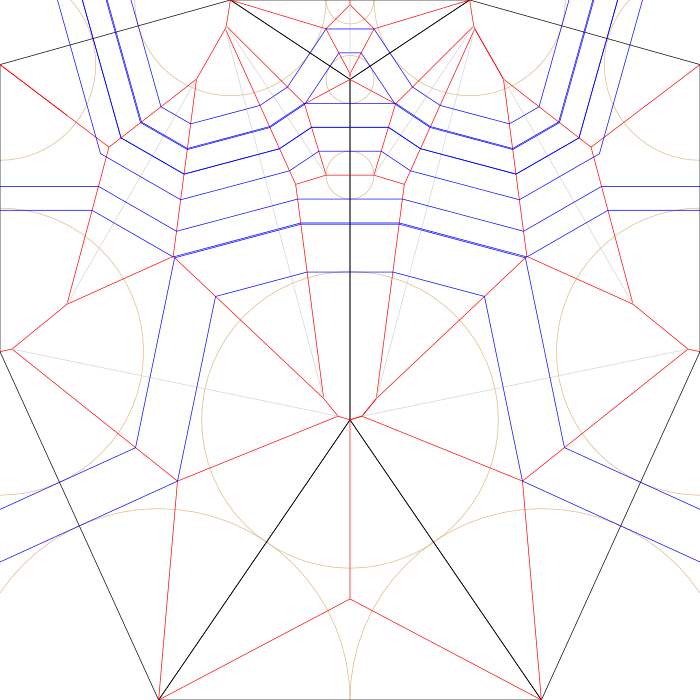

In [1]:
import networkx as nx
import numpy as np
from itertools import count
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from shapely.geometry.polygon import orient
from shapely.ops import split, linemerge, nearest_points, polygonize
from shapely.affinity import rotate, translate, scale
from shapely import wkt
from sample_trees import *
from render_pattern import *

step = 10
epsilon = 3
rounding_precision = 6

def nodes_with_attribute(tree,att): return [n for n,d in tree.nodes(data=True) if d==att]
def interior_nodes(tree): return nodes_with_attribute(tree,{})
def tree_distance_from_points(d,point1,point2,ids): return d[ids[point1]][ids[point2]]
def tree_distance_from_line(d,line,ids): return tree_distance_from_points(d,line.coords[0],line.coords[-1],ids)
def get_edge_weight (T,node): return[(c["weight"]) for (a, b, c) in T.edges(node,data=True)][0]

def are_colinear(p1,p2,p3): return p2.intersects(line_from_points(p1,p3)) and not (p1.equals(p2) or p1.equals(p3) or p2.equals(p3))
def point_in_origin(ids,original_ids,point): return point_from_node(node_from_point(point,ids),original_ids)
def point_from_node(node, ids): return Point(next((point for point, i in ids.items() if i == node), None))
def node_from_point (point,ids): return ids[point.coords[0]]
def near_point_on_line(line,p): return Point(line.intersection(p.buffer(0.1)).coords[0]) 
def point_distance (ids,id1,id2): return point_from_node(id1,ids).distance(point_from_node(id2,ids))

def index_from_vertex(polygon,vertex): return polygon.exterior.coords[:].index(vertex.coords[0])
def distance_to_origin(ids,original_ids,point): return Point(point).distance(point_in_origin(ids,original_ids,point))
def buffer_line_symmetric(line_segments,offset): return [line_segments.parallel_offset(offset,'left', join_style=2),line_segments.parallel_offset(offset,'right', join_style=2)]

def azimuth(point1, point2): return np.degrees(np.arctan2(point2.x - point1.x, point2.y - point1.y))
def line_move_to (line,point): return translate(line, point.x- start_point(line).x,point.y - start_point(line).y)
def line_orthogonal(line): return rotate(line,90,origin=start_point(line))
def line_stretch_to_size (line,size): return scale(line,xfact=size/line.length,yfact=size/line.length,origin=start_point(line))

def approximate_line(line): return wkt.loads(wkt.dumps(line,rounding_precision=rounding_precision))
def ids_from_line(line,ids): return ids[start_point(line).coords[0]],ids[end_point(line).coords[0]]
def line_from_ids(id1,id2,ids): return line_from_points(point_from_node(id1,ids),point_from_node(id2,ids))
def line_from_points(p1,p2): return LineString([p1,p2])
def line_in_origin(ids,original_ids,line): return line_from_points(point_in_origin(ids,original_ids,start_point(line)),point_in_origin(ids,original_ids,end_point(line)))
def line_on_polygon(line,polygon): return line.relate(polygon) == 'F1FF0F212'
def line_not_in_multiline(line,lines): return line.relate(lines) == 'FF100F102'
def start_point(line): return Point(line.coords[0])
def end_point(line): return Point(line.coords[-1])

def polygon_edge(polygon,i1,i2): return LineString([polygon.exterior.coords[i1],polygon.exterior.coords[i2]])
def polygon_from_vertex(polygons,vertex): return [p for p in polygons if vertex.coords[0] in p.exterior.coords]
def vertices_from_polygon(polygon): return MultiPoint(polygon.exterior.coords[:-1])
def coords_from_poly(polygon): return polygon.exterior.coords[:]
def vertex_from_polygon(polygon,index): return polygon.exterior.coords[index]
def project_on_origin(ids,original_ids,p1,polygon,h):
    edge = [polygon_edge(polygon,i,i+1) for i,p in enumerate(vertices_from_polygon(polygon)) if p1.almost_equals(p,rounding_precision)]
    d = line_in_origin(ids,original_ids,*edge).project(p1)
    return d if d>0 else h/2

def find_colinear_points(points): return [points[i-1] for i in range(len(points)) if are_colinear(points[i-2],points[i-1],points[i])]

def is_split_event(c,poly,ids,ids_origin,d,h): return calculate_distances(start_point(c),end_point(c),ids,ids_origin,poly,h)-tree_distance_from_line(d,c,ids)< epsilon if not poly.touches(c) else False
def calculate_distances(p1,p2,ids,origin,poly,h): return project_on_origin(ids,origin,p1,poly,h) + Point(p1).distance(Point(p2)) + project_on_origin(ids,origin,p2,poly,h) 
def connect_points(points): return [line_from_points(points.centroid,p) for p in vertices_from_polygon(points)]
def contract_triangle(polygon):
    shrunk_poly = polygon.buffer(-1) 
    lines = [line_stretch_to_size(line_from_points(v,vertex_from_polygon(shrunk_poly,i)),polygon.length) for i,v in enumerate(vertices_from_polygon(polygon))]
    intersection = lines[0].intersection(lines[1])
    return [line_from_points(v,intersection) for v in vertices_from_polygon(polygon)]
    

def path_to_leaf(node,tree,path = []):
    for n in tree.neighbors(node):
        if tree.degree(n) == 1: #found a leaf!
            return path+[n]
    path_to_leaf(n,tree,path+[n])
    


def adjacent_edge(polygon,vertex):
    index = index_from_vertex(polygon,vertex)
    return [polygon_edge(polygon,index,index+1), polygon_edge(polygon,index-1,index)]

def shrink_polygon(polygon,sweep_length,ids,distances,active,ids_origin,h_last=0,creases=[],guides=[],h=0):    
   # shrink the polygon
    shrunk_poly = polygon.buffer(-sweep_length) 
    h+=sweep_length
    
    # look for contraction events
    if shrunk_poly.is_empty: 
        creases += connect_points(polygon)
        return creases, guides 
    
    # look for split events
    if len(coords_from_poly(polygon)) > 4:          # ignore triangles as no split event can happen here
        # find the active paths
        a = query_matrix(active,1) 
        for nodes in a:
            cut_path = line_from_ids(nodes[0],nodes[1],ids)
            if is_split_event(cut_path,
                              polygon,
                              ids,
                              ids_origin,
                              distances,h_last): 
                guides.append(cut_path)
                [shrink_polygon(p,sweep_length,ids.copy(),distances,get_active_paths(p,ids, distances),ids,h,creases,guides,h) for p in split(polygon, cut_path)]
                return creases,guides
    
    # contract triangles right away
    else:     
        creases += contract_triangle(polygon)
        return creases,guides

    shrunk_poly = inject_colinear_points(polygon,shrunk_poly)
            
    # generate creases        
    for i,p in enumerate(coords_from_poly(polygon)):
        extend_lines(creases,LineString([p,shrunk_poly.exterior.coords[i]]))
        if i>0: ids[shrunk_poly.exterior.coords[i]] = ids.pop(p)

    # recursively call the shrinking with the new polygon
    return shrink_polygon(shrunk_poly,
                          sweep_length,
                          ids,distances,
                          active,
                          ids_origin,
                          h_last,
                          creases,
                          guides,h)

def inject_colinear_points(source_poly,target_poly):
    coords = coords_from_poly(target_poly)
    colinear = find_colinear_points(vertices_from_polygon(source_poly))    
    for col_point in colinear:
        p = nearest_point_on_polygon(col_point,target_poly) 
        coords.insert(index_from_vertex(source_poly,col_point),p)
        if (coords[0] == p): del coords[-1]
    return Polygon(coords)

def nearest_point_on_polygon(point,polygon): 
    points = nearest_points(point,polygon)
    return points[1] if points[0] == point else points[0]

def convex_polygon_from_points(points): return Polygon(points).convex_hull
    
def extend_lines(lines,extension):
    for i,line in enumerate(lines):
        if approximate_line(extension).touches(approximate_line(line)):
            merge = linemerge(MultiLineString([extension,line]))
            if type(merge) == LineString: lines[i] = merge
            return lines
    lines.append(extension)
    return lines

def get_active_paths(polygon,ids,d):
    paths = np.zeros((len(ids),len(ids)))
    for p1 in coords_from_poly(polygon):
        for p2 in coords_from_poly(polygon):
            if ids[p1] > ids[p2]:
                paths[ids[p1]][ids[p2]] = 1 if abs(Point(p1).distance(Point(p2))-tree_distance_from_points(d,p1,p2,ids)) > epsilon else -1
    return paths

def first_intersection (line,other_lines):
    ref = float('inf')
    intersection_point = intersecting_line = None
    for other_line in other_lines:
        intersection = line.intersection(other_line) 
        if not intersection.is_empty:
            for point in [intersection]:
                distance = start_point(line).distance(point)
                if epsilon < distance < ref: 
                    intersection_point,intersecting_line,ref = point,other_line,distance
    return intersection_point, intersecting_line

def propagate_line(line,creases,segments):
    intersection_point, intersecting_crease = first_intersection(line,creases)
    if intersection_point == None: return extend_lines(segments,line)[-1]
    segments = extend_lines(segments,line_from_points(start_point(line),intersection_point))
    line_slope = azimuth(start_point(line),intersection_point)
    crease_slope = azimuth(near_point_on_line(intersecting_crease,intersection_point),intersection_point)
    newline = line_move_to(rotate(line, 180+2*(line_slope - crease_slope), origin=intersection_point),intersection_point)
    return propagate_line(newline,creases, segments)

def query_matrix(m,val):
    res = np.where(m==val)
    return list(zip(res[0],res[1]))

def get_lang_polys(points,ids,active):
    # add all active edges to the polys
    polys = [line_from_ids(point_ids[0],point_ids[1],ids) for point_ids in query_matrix(active,-1)] 
    
    # find inactive edges
    inactive = [line_from_ids(point_ids[0],point_ids[1],ids) for point_ids in query_matrix(active,1)] 
    
    #add inactive edges to polygon if they are on the outside
    polys += [line for line in inactive if line_on_polygon(line,convex_polygon_from_points(points)) and line_not_in_multiline(line,MultiLineString(polys))] 
    
    return list(polygonize(polys)) if len(list(polygonize(polys))) >0 else [MultiPoint(points).convex_hull]


def generate_rivers(polygons,tree,ids,dist,cr,rivers=[],visited=[]):
    for node in interior_nodes(tree):
        path = path_to_leaf(node,tree)
        leaf = point_from_node(path[-1],ids)
        polygon = polygon_from_vertex(polygons,leaf)[0]
        edges = adjacent_edge(polygon,point_from_node(path[-1],ids))
        for edge in edges:
            nodes_on_edge = nx.shortest_path(tree,*ids_from_line(edge,ids))
            if node in nodes_on_edge and len(nodes_on_edge)>3: 
                    e = line_from_points(leaf,end_point(edge)) if start_point(edge) == leaf else line_from_points(leaf,start_point(edge))
                    other_node = nodes_on_edge[nodes_on_edge.index(node)-1]
                    other_node = other_node if other_node in interior_nodes(tree) else nodes_on_edge[nodes_on_edge.index(node)+1]
                    if not ((node,other_node) in visited):
                        width = dist[other_node][node]/2
                        start = e.interpolate(get_edge_weight(tree,path[-1]) + width)
                        line = line_move_to(line_orthogonal(line_stretch_to_size(e,polygon.length)),start)
                        rivers += buffer_line_symmetric(propagate_line(line,cr,[]),width)
                        rivers += buffer_line_symmetric(propagate_line(rotate(line,180,origin=start),cr,[]),width)
                        visited.extend([(other_node,node),(node,other_node)])
    return rivers

crease_lines=rivers=guide_lines=polys=circles=points=[]
points,point_ids,T,tree_distances = beetleTree()#beetleTree()#threeNodesTree()#lizardTree()#antennaBeetleTree()

circles = [point.buffer(get_edge_weight(T,node_from_point(point,point_ids))) for point in points]
active_paths = get_active_paths(Polygon(points),point_ids,tree_distances)
polys = get_lang_polys(points,point_ids,active_paths)

for polygon in polys:
    active_paths = get_active_paths(polygon,point_ids,tree_distances)
    crease_lines,guide_lines = shrink_polygon(polygon,step,point_ids.copy(),tree_distances,active_paths,point_ids)

rivers = generate_rivers(polys,T,point_ids,tree_distances,crease_lines)
render(points,circles,crease_lines,guide_lines,polys,rivers)




In [109]:
P = Polygon([[0, 0], [1, 0], [1, 1], [0, 0]])

print(P.centroid)

POINT (0.6666666666666666 0.3333333333333333)


In [2]:
for p1,p2 in combinations(range(10),2):
    print (p1,p2)
    
for p1 in range(10):
    for p2 in range(10):
        print(p1,p2)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
